## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(sys)
print(parameter_names)

2.154434690031884
Combined
[['amplitude', 'index'], ['amplitude', 'lambda_'], ['lambda_', 'index']]


In [4]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.49 s, sys: 229 ms, total: 6.72 s
Wall time: 6.83 s


## Datasets

In [5]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 10
    
if sys == "E_reco":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
    dataset_asimov_N.irf_model.parameters['norm'].frozen = True
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 2000
    
    
if sys == "Combined":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['norm'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 2000

    
if sys == "BKG":

    # piece wise model
    # remove old bkg model
    setup.set_up_bkg_sys_V( breake = 10,
                        index1 = 2,
                        index2 = 1.5, 
                        magnitude = magnitude )

    dataset_asimov, dataset_asimov_N = setup.run()

    setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)

## Minos

In [6]:
        
numpoints = 20

In [7]:
parameter_names

[['amplitude', 'index'], ['amplitude', 'lambda_'], ['lambda_', 'index']]

In [8]:
def computing_contour(dataset, note, idx = 0):
        
    
    results = []
    for parname1, parname2 in parameter_names[idx:idx+1] :
        print( parname1, parname2)
        
        minuit_opts = {"tol": 10, "strategy": 1}
        fit_cor.backend = "minuit"
        fit_cor.optimize_opts = minuit_opts
        result = fit_cor.stat_contour(dataset,
                             dataset.models.parameters[parname1],
                             dataset.models.parameters[parname2],
                                      numpoints=numpoints 
                            )

        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "success":
                contour_write[k] = result[k].tolist()

        with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}_{e_reco_n}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)

        fig = plt.figure()
        case1 = "spectral"; case2 = "spectral" 
        if parname1 not in ['amplitude', 'index', 'lambda_']:
            case1 = 'spatial'
        if parname2 not in ['amplitude', 'index', 'lambda_']:
            case2 = 'spatial'
            
        plt.plot(result[f"{dataset.models[0].name}.{case1}.{parname1}"],
        result[f"{dataset.models[0].name}.{case2}.{parname2}"])
        results.append(result)
    return results
        
def read_in_contour(note):
    results = []
    for parname1, parname2 in parameter_names :
        with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}_{e_reco_n}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        results.append(contour)
    return results

def read_in_contour_one(note, idx):
    results = []
    for parname1, parname2 in parameter_names[idx:idx+1] :
        with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}_{e_reco_n}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        results.append(contour)
    return results

In [9]:
%%time
dataset_asimov.models.parameters['lon_0'].frozen = True
dataset_asimov.models.parameters['lat_0'].frozen = True

fit_cor = Fit()
result = fit_cor.run(dataset_asimov)

CPU times: user 5.47 s, sys: 2.02 s, total: 7.5 s
Wall time: 7.51 s


In [10]:
result.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.928e+04                  │              Nfcn = 83               │
│ EDM = 4.54e-10 (Goal: 0.0002)    │            time = 7.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.30    │   0.09    │            │            │         │         │       │
│ 1 │ par_001_amplitude │   3.85    │   0.25    │            │            │         │         │       │
│ 2 │ par_002_lambda_   │    1.0    │    0.4    │            │            │         │         │       │
│ 3 │ par_003_norm      │   1.000   │   0.011   │            │            │         │         │       │
│ 4 │ par_004_tilt      │   0.000   │   0.012   │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude   par_002_lambda_      par_003_norm      par_004_tilt │
├───────────────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     par_000_index │           0.00778            -0.015            -0.028                -0          -0.03e-3 │
│ par_001_amplitude │            -0.015            0.0626              0.08          -0.08e-3                -0 │
│   par_002_lambda_ │            -0.028              0.08             0.145           0.01e-3                -0 │
│      par_003_norm │                -0          -0.08e-3           0.01e-3          0.000115           0.01e-3 │
│      par_004_tilt │          -0.03e-3                -0                -0           0.01e-3          0.000134 │
└───────────────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

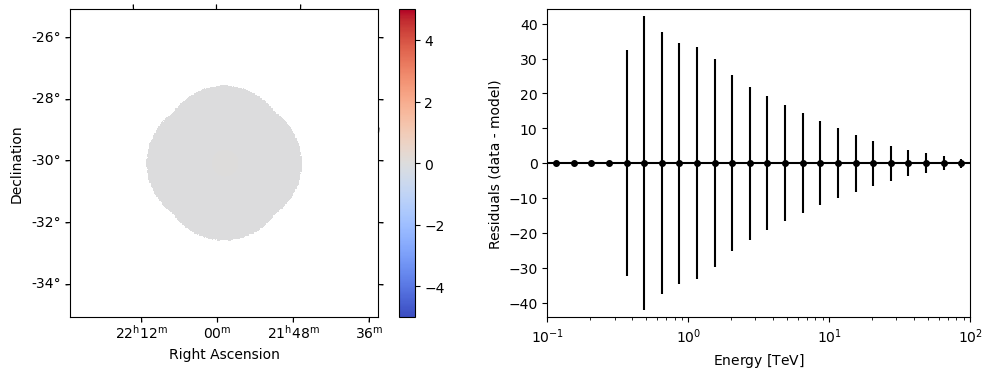

In [11]:
dataset_asimov.plot_residuals()

In [12]:
%%time
numpoints = 20
computing = 0
if computing:
    results = computing_contour(dataset_asimov, "2.15h", 0)
    results = computing_contour(dataset_asimov, "2.15h", 1)
    results = computing_contour(dataset_asimov, "2.15h", 2)
else:
    results = read_in_contour("2.15h")
    #results = read_in_contour_one("2.15h",0 )
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    


CPU times: user 28.1 ms, sys: 2.13 ms, total: 30.3 ms
Wall time: 35.6 ms


In [13]:
%%time
dataset_asimov_N.e_reco_n = e_reco_n

dataset_asimov_N.models.parameters['lon_0'].frozen = True
dataset_asimov_N.models.parameters['lat_0'].frozen = True

fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run(dataset_asimov_N)
print(result_cor)
print(dataset_asimov_N.models)
result_cor.minuit

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 176
	total stat : 89284.15

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

DatasetModels

Component 0: SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.14             
    amplitude                     :   3.85e-11   +/- 4.7e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.100   +/-    0.04 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                 (frozen):    329.680       deg         
    lat_0        

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.928e+04                  │              Nfcn = 176              │
│ EDM = 9e-05 (Goal: 0.0002)       │           time = 272.6 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.30    │   0.14    │            │            │         │         │       │
│ 1 │ par_001_amplitude │    3.9    │    0.5    │            │            │         │         │       │
│ 2 │ par_002_lambda_   │    1.0    │    0.4    │            │            │         │         │       │
│ 3 │ par_003_norm      │   1.000   │   0.011   │            │            │         │         │       │
│ 4 │ par_004_tilt      │  -0.000   │   0.012   │            │            │         │         │       │
│ 5 │ par_005_bias      │   -0.00   │   0.05    │            │            │         │         │       │
│ 6 │ par_006_norm      │   -0.0    │    0.1    │            │            │         │         │       │
│ 7 │ par_007_tilt      │   -0.00   │   0.02    │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude   par_002_lambda_      par_003_norm      par_004_tilt      par_005_bias      par_006_norm      par_007_tilt │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     par_000_index │            0.0201            -0.024            -0.043           0.01e-3          -0.02e-3            0.0058              0.00                 0 │
│ par_001_amplitude │            -0.024              0.22              0.09          -0.09e-3          -0.01e-3           -0.0043            -0.039                -0 │
│   par_002_lambda_ │            -0.043              0.09             0.163                -0          -0.01e-3           -0.0072            -0.000                -0 │
│      par_003_norm │           0.01e-3          -0.09e-3                -0          0.000115           0.01e-3           0.01e-3                 0                 0 │
│      par_004_tilt │          -0.02e-3          -0.01e-3          -0.01e-3           0.01e-3          0.000134                 0                 0                -0 │
│      par_005_bias │            0.0058           -0.0043           -0.0072           0.01e-3                 0           0.00277            0.0000                 0 │
│      par_006_norm │              0.00            -0.039            -0.000                 0                 0            0.0000            0.0101                 0 │
│      par_007_tilt │                 0                -0                -0                 0                -0                 0                 0            0

In [ ]:
%%time
computing = 1
numpoints = 10

if computing:
    #results_N = computing_contour(dataset_asimov_N, "N_2.15h",0)
    results_N = computing_contour(dataset_asimov_N, "N_2.15h",1)
    #results_N = computing_contour(dataset_asimov_N, "N_2.15h",2)
else:
    results_N = read_in_contour("N_2.15h")
    #results_N = read_in_contour_one("N_2.15h", 0)
    
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        


amplitude lambda_


In [ ]:
fig,axs = plt.subplots(2,2)
#axs = axs.flatten()
axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
for i,p in enumerate(parameter_names):
    a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    axs[i].plot(a, b, color = awo[0])
    axs[i].errorbar(x = dataset_asimov.models[0].parameters[p[0]].value,
                    y = dataset_asimov.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov.models[0].parameters[p[1]].error,
                    color = awo[0],
                    capsize = 6,
                    label = "fit w/o systematic"
                    
                   )
    
    a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    axs[i].plot(a, b, color = aw[0], marker = 'x' , linestyle = '' )
    axs[i].errorbar(x = dataset_asimov_N.models[0].parameters[p[0]].value,
                    y = dataset_asimov_N.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov_N.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov_N.models[0].parameters[p[1]].error,
                    color = aw[0],
                    capsize = 6,
                    label = "fit with systematic"
                   )
    axs[i].errorbar(x = dataset_input.models[0].parameters[p[0]].value,
                    y = dataset_input.models[0].parameters[p[1]].value,
                    color = 'black',
                    marker = 'v',
                    capsize = 6,
                    label = "input"
                   )
    axs[i].set_xlabel(p[0])
    axs[i].set_ylabel(p[1])  
plt.tight_layout()
axs[-1].axis('off')
plt.savefig(f"../{c['folder']}/plots/3_contours.pdf")

In [ ]:
parameter_names

In [ ]:
from scipy.interpolate import interp1d
def interpolate(one, two):
    
    points = np.column_stack((one, two))  # a (nbre_points x nbre_dim) array
    

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods: #quadratic
    interpolations_methods = ['quadratic']
    alpha = np.linspace(0, 1, 75)

    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)
        
    for method_name, curve in interpolated_points.items():
        c_int = {'x':curve.T[0], 'y': curve.T[1]}
    return np.array(c_int['x']), np.array(c_int['y'])



In [ ]:
fig,axs = plt.subplots(2,2)
#axs = axs.flatten()
axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
for i,p in enumerate(parameter_names):
    a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    a, b = interpolate(a,b)
    axs[i].plot(a, b, color = awo[0])
    axs[i].errorbar(x = dataset_asimov.models[0].parameters[p[0]].value,
                    y = dataset_asimov.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov.models[0].parameters[p[1]].error,
                    color = awo[0],
                    capsize = 6,
                    label = "fit w/o systematic"
                    
                   )
    
    a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    a, b = interpolate(a,b)
    
    axs[i].plot(a, b, color = aw[0], )
    #axs[i].plot(a, b, color = aw[0], marker = 'x' , linestyle = '' )
    axs[i].errorbar(x = dataset_asimov_N.models[0].parameters[p[0]].value,
                    y = dataset_asimov_N.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov_N.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov_N.models[0].parameters[p[1]].error,
                    color = aw[0],
                    capsize = 6,
                    label = "fit with systematic"
                   )
    axs[i].errorbar(x = dataset_input.models[0].parameters[p[0]].value,
                    y = dataset_input.models[0].parameters[p[1]].value,
                    color = 'black',
                    marker = 'v',
                    capsize = 6,
                    label = "input"
                   )
    axs[i].set_xlabel(p[0])
    axs[i].set_ylabel(p[1])  
plt.tight_layout()
axs[-1].axis('off')
plt.savefig(f"../{c['folder']}/plots/3_contours.pdf")